<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GA Capstone: Fake News Classifier

Author: Tan Kai Yong Alvin

# Notebook 2-2: Modeling (PyCaret)

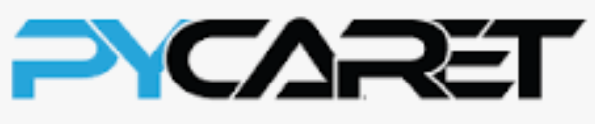

In this section, PyCaret an auto ML tool will be used to for selction of the best model.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

# preprocessing of data
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # split our data and run hyperparameter search
from pycaret.classification import *

## Import

In [2]:
classification_df = pd.read_csv('./datasets/classification_df.csv')

In [3]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 44679 non-null  object
 1   original_title_text  44689 non-null  object
 2   classification_text  44680 non-null  object
 3   label                44689 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [4]:
classification_df.head()

,date,original_title_text,classification_text,label
0,2017-12-31,"As U.S. budget fight looms, Republicans flip t...",u budget fight loom republican flip fiscal scr...,0
1,2017-12-29,U.S. military to accept transgender recruits o...,u military accept transgender recruit monday p...,0
2,2017-12-31,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u republican senator let mr mueller job...,0
3,2017-12-30,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...,0
4,2017-12-29,Trump wants Postal Service to charge 'much mor...,trump want postal service charge much amazon s...,0


In [5]:
# check for nulls
# the nulls in the dates column will not be processed for now as it will not be used for the assessment
classification_df[classification_df['classification_text'].isnull()]

,date,original_title_text,classification_text,label
30569,NaN,https://100percentfedup.com/served-roy-moore-v...,NaN,1
36715,NaN,https://100percentfedup.com/video-hillary-aske...,NaN,1
36716,NaN,https://100percentfedup.com/12-yr-old-black-co...,NaN,1
37047,NaN,https://fedup.wpengine.com/wp-content/uploads/...,NaN,1
37048,NaN,https://fedup.wpengine.com/wp-content/uploads/...,NaN,1
38640,NaN,https://fedup.wpengine.com/wp-content/uploads/...,NaN,1
38641,NaN,https://fedup.wpengine.com/wp-content/uploads/...,NaN,1
43077,NaN,https://fedup.wpengine.com/wp-content/uploads/...,NaN,1
43078,NaN,https://fedup.wpengine.com/wp-content/uploads/...,NaN,1


In [6]:
# these nulls are made up of white spaces with title comprising of URLs, since they are not useful for prediction, the rows will be dropped.
classification_df.dropna(subset=['classification_text'], inplace = True)
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44680 entries, 0 to 44688
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 44679 non-null  object
 1   original_title_text  44680 non-null  object
 2   classification_text  44680 non-null  object
 3   label                44680 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [7]:
# classification_df['date'] = pd.to_datetime(classification_df['date'])

In [8]:
# define X and y
X = classification_df['classification_text']
y = classification_df['label']

## Modeling

Selection of parameter:

* Since it was determined from theNotebook 2 Modeling that Count Vectorizer is able to outperform TF-IDF Vectorizer, Count Vectorizer will be applied as the vectorization step for PyCaret. (Note: TF-IDF vectorizer was incorporated in one of the Pycaret runs but was unable to outperform Count Vectorizer).

* Previous modeling showed that increasing the 'max_features' beyond 3,000 would have significant demands on hardware and software, calculation time. On the other hand, the potential contribution of the higher 'max_features' in increasing the accuracy of created models is very limited. Hence, we will limit the 'max_features' used in PyCaret as 3,000.

* Similar to the above, increasing the ngrams would increase the accuracy score but this comes in the expense of significant demands on hardware, software and calculation time. Hence, we will limit the ngrams to up to 3(trigram) for the purpose of PyCaret modeling

### Train test split

In [9]:
# Define training and testing sets. Train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

### Setting up Pycaret 

In [10]:
# Apply Count Vectorizer
cvec = CountVectorizer(min_df=0.001, max_features=3000, ngram_range=(1,3)) 

In [11]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train.values).todense(), columns = cvec.get_feature_names())

In [12]:
# vectorization of test data set
X_test_cvec = pd.DataFrame(cvec.transform(X_test.values).todense(), columns = cvec.get_feature_names())

In [13]:
pyca_df = pd.concat([X_train_cvec, y_train.reset_index(drop=True)], axis=1)

In [14]:
pyca_df.shape

(33510, 3001)

In [15]:
pyca_df.head()

,10,100,100000,11,12,13,14,15,16,17,18,19,20,200,2000,2001,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2016 election,2016 presidential,2017,2017realdonaldtrump,2018,2019,21,21wiretv,22,23,24,25,26,27,28,29,30,31,35,40,45,50,500,60,70,80,90,911,abc,abe,ability,able,abortion,abroad,absolutely,abuse,accept,accepted,access,accord,according,account,accusation,accused,accusing,achieve,acknowledged,acr,across,across country,act,acting,action,active,activist,activity,actor,actual,actually,ad,adam,add,added,adding,addition,additional,address,administration,administration official,admitted,adult,advance,advantage,advice,adviser,advisor,advocate,affair,affect,affected,affordable,affordable care,affordable care act,afghan,afghanistan,afraid,africa,african,africanamerican,afternoon,age,agency,agenda,agent,aggressive,ago,agree,agreed,agreement,ahead,aid,aide,aim,aimed,air,air force,aircraft,airline,airport,al,al qaeda,alabama,alex,ali,alien,allegation,alleged,allegedly,alliance,allow,allowed,allowing,allows,ally,almost,alone,along,alongside,already,also,also said,alternative,although,always,amazing,ambassador,amendment,america,america great,american,american people,amid,amnesty,among,amount,analysis,analyst,andrew,angela,angela merkel,angeles,anger,angry,animal,ankara,announce,announced,announcement,annual,anonymity,another,answer,anthem,antifa,antitrump,anybody,anymore,anyone,anything,apart,apparent,apparently,appeal,appeal court,appear,appearance,appeared,appears,apple,application,apply,appointed,appointment,approach,appropriate,approval,approve,approved,april,arab,arabia,area,argue,argued,argument,arizona,arm,armed,army,around,around world,arrest,arrested,arrival,arrived,art,article,asia,asian,aside,ask,asked,asking,asks,aspect,assad,assault,assembly,assessment,asset,assistance,assistant,...,transition team,travel,travel ban,treasury,treat,treated,treatment,treaty,trial,tried,trillion,trip,troop,trouble,truck,true,truly,trump,trump administration,trump also,trump campaign,trump jr,trump made,trump rally,trump republican,trump said,trump say,trump supporter,trump told,trump tower,trump would,trust,truth,try,trying,tuesday,turkey,turkish,turn,turned,turning,tv,tweet,tweeted,twice,two,two week,two year,type,uk,ukraine,ultimately,un,unable,uncertainty,unclear,undermine,understand,understanding,undocumented,unfortunately,union,unit,united,united nation,united state,unity,university,unless,unlike,unlikely,unprecedented,upon,upset,urge,urged,urging,us,usa,use,used,user,using,usual,usually,value,van,various,vast,vega,vehicle,venezuela,version,veteran,veto,via,via video,via video screen,vice,vice president,victim,victory,video,video screen,video screen capture,video via,vietnam,view,viewer,village,violated,violation,violence,violent,virginia,visa,vision,visit,visited,visiting,vladimir,vladimir putin,voice,vote,voted,voter,voting,vowed,vulnerable,wage,wait,waiting,wake,walk,walking,wall,wall street,want,wanted,war,warming,warned,warning,warrant,warren,washington,washington dc,washington post,washington president,washington president donald,watch,watched,watching,water,wave,way,weak,wealth,wealthy,weapon,wearing,website,wednesday,week,weekend,welcome,welcomed,welfare,well,went,west,western,whatever,whether,white,white house,white house official,white house said,white people,white supremacist,whole,whose,widely,widespread,wife,wikileaks,william,williams,willing,win,window,wing,winner,winning,wire,wire say,wisconsin,wish,within,without,witness,woman,wonder,wont,word,work,worked,worker,working,world,world war,worried,worry,worse,worst,worth,would,would allow,would also,would like,would make,would take,wounded,wow,writer,writing,written,wrong,wrote,xi,year,year ago,year old,yemen,yes,yesterday,yet,yet another,york,york city,york time,young,youre,youth,youtube,zero,zika,zimbabwe,zone,label
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [16]:
numeric_cols = list(pyca_df.columns)
numeric_cols = numeric_cols[:-1]

In [17]:
pyca_model = setup(data = pyca_df, numeric_features = numeric_cols, target = 'label', session_id=1, )

,Description,Value
0,session_id,1
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(33510, 3001)"
5,Missing Values,False
6,Numeric Features,3000
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [18]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9865,0.9989,0.9850,0.9893,0.9871,0.9730,0.9730,1.7490
lr,Logistic Regression,0.9832,0.9966,0.9844,0.9837,0.9840,0.9664,0.9664,10.3110
svm,SVM - Linear Kernel,0.9824,0.0000,0.9840,0.9826,0.9833,0.9648,0.9648,1.2280
rf,Random Forest Classifier,0.9807,0.9981,0.9746,0.9885,0.9815,0.9614,0.9615,5.9240
et,Extra Trees Classifier,0.9805,0.9982,0.9723,0.9904,0.9813,0.9610,0.9612,11.3580
ridge,Ridge Classifier,0.9705,0.0000,0.9725,0.9712,0.9719,0.9408,0.9408,1.1230
lda,Linear Discriminant Analysis,0.9703,0.9939,0.9723,0.9712,0.9717,0.9405,0.9405,33.4380
gbc,Gradient Boosting Classifier,0.9605,0.9940,0.9526,0.9716,0.9620,0.9208,0.9211,20.2330
ada,Ada Boost Classifier,0.9591,0.9923,0.9577,0.9641,0.9609,0.9180,0.9180,4.6020
dt,Decision Tree Classifier,0.9362,0.9359,0.9423,0.9366,0.9394,0.8721,0.8721,5.7150


Based on the result generated by Pycaret, the following models are selected for hyperparameter tuning and further evaluation:

- **Light Gradient Boosting Machine**. This is the best performing model in terms of Accuracy and Recall. LGBM will most likely outperform the other tree based models as LGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage. LGBM splits the tree leaf-wise as opposed to other boosting algorithms that grow tree level-wise. It chooses the leaf with maximum delta loss to grow. Since the leaf is fixed, the leaf-wise algorithm has lower loss compared to the level-wise algorithm. Leaf-wise tree growth might increase the complexity of the model and may lead to overfitting in small datasets.

- **Logistic Regression**. Logistic Regression is the second best performing model. Logistic regression is suitable for application on binary classification problem. This is also one of the more explanable and efficient model.

- **SVM - Linear Kernel**. SVM is selected as it has one of the best Accuracy and Recall scores.


#### Create Model

In [19]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9885,0.9992,0.9903,0.9879,0.9891,0.9769,0.9769
1,0.9868,0.9991,0.9821,0.9926,0.9873,0.9735,0.9736
2,0.9817,0.9986,0.9797,0.9853,0.9825,0.9633,0.9633
3,0.9868,0.9988,0.9846,0.9902,0.9874,0.9735,0.9735
4,0.9885,0.9989,0.9870,0.9910,0.9890,0.9769,0.9769
5,0.9881,0.9990,0.9862,0.9910,0.9886,0.9761,0.9761
6,0.9881,0.9988,0.9894,0.9878,0.9886,0.9761,0.9761
7,0.9855,0.9987,0.9829,0.9894,0.9861,0.9709,0.9710
8,0.9893,0.9993,0.9886,0.9910,0.9898,0.9786,0.9786


In [20]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9800,0.9958,0.9781,0.9837,0.9809,0.9598,0.9599
1,0.9800,0.9955,0.9821,0.9797,0.9809,0.9598,0.9598
2,0.9842,0.9960,0.9838,0.9862,0.9850,0.9684,0.9684
3,0.9859,0.9968,0.9870,0.9862,0.9866,0.9718,0.9718
4,0.9851,0.9977,0.9862,0.9854,0.9858,0.9701,0.9701
5,0.9842,0.9981,0.9870,0.9830,0.9850,0.9684,0.9684
6,0.9842,0.9973,0.9903,0.9799,0.9851,0.9683,0.9684
7,0.9868,0.9980,0.9878,0.9870,0.9874,0.9735,0.9735
8,0.9842,0.9955,0.9846,0.9854,0.9850,0.9684,0.9684


In [21]:
svm_model = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9817,0.0000,0.9821,0.9829,0.9825,0.9633,0.9633
1,0.9821,0.0000,0.9813,0.9845,0.9829,0.9641,0.9641
2,0.9859,0.0000,0.9870,0.9862,0.9866,0.9718,0.9718
3,0.9847,0.0000,0.9821,0.9886,0.9853,0.9692,0.9693
4,0.9851,0.0000,0.9854,0.9862,0.9858,0.9701,0.9701
5,0.9808,0.0000,0.9821,0.9813,0.9817,0.9615,0.9615
6,0.9846,0.0000,0.9911,0.9799,0.9855,0.9692,0.9693
7,0.9808,0.0000,0.9805,0.9829,0.9817,0.9615,0.9615
8,0.9791,0.0000,0.9838,0.9766,0.9802,0.9581,0.9581


#### Hyperparameter Tuning

In [22]:
tuned_lightgbm_model= tune_model(lightgbm_model, choose_better =True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9932,0.9993,0.9919,0.9951,0.9935,0.9863,0.9863
1,0.9859,0.9991,0.9821,0.9910,0.9865,0.9718,0.9719
2,0.9893,0.9992,0.9878,0.9918,0.9898,0.9786,0.9786
3,0.9906,0.9995,0.9870,0.9951,0.9910,0.9812,0.9812
4,0.9902,0.9993,0.9894,0.9919,0.9906,0.9803,0.9803
5,0.9906,0.9993,0.9870,0.9951,0.9910,0.9812,0.9812
6,0.9915,0.9996,0.9927,0.9911,0.9919,0.9829,0.9829
7,0.9893,0.9993,0.9894,0.9902,0.9898,0.9786,0.9786
8,0.9923,0.9997,0.9911,0.9943,0.9927,0.9846,0.9846


In [23]:
# tuned lightgbm_model
print(tuned_lightgbm_model)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=100, min_child_weight=0.001,
               min_split_gain=0.6, n_estimators=280, n_jobs=-1, num_leaves=70,
               objective=None, random_state=1, reg_alpha=0.1, reg_lambda=0.001,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [24]:
# to compare the hyperparameters with untuned model
print(lightgbm_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


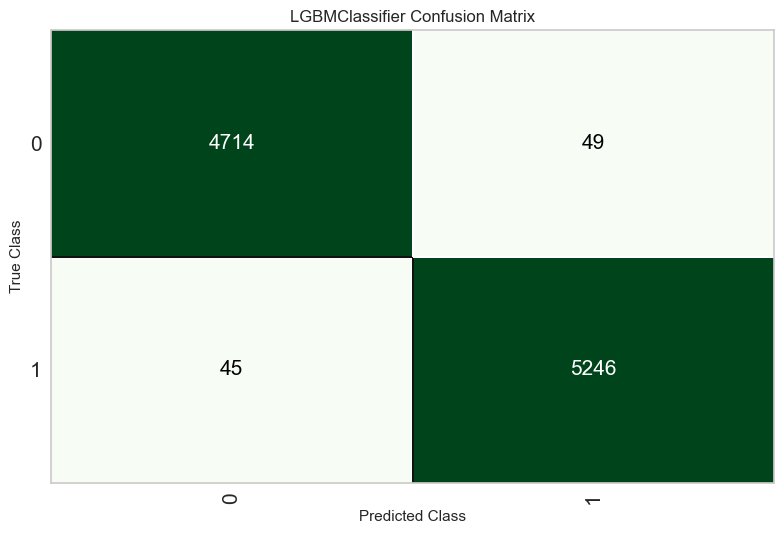

In [25]:
plot_model(tuned_lightgbm_model, plot = 'confusion_matrix')

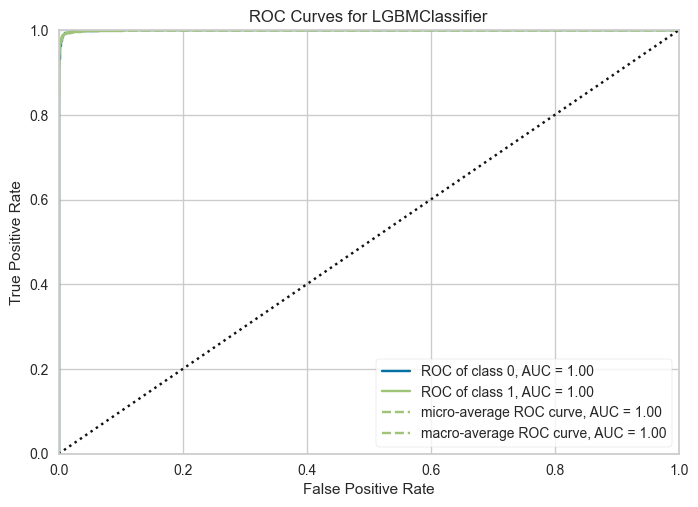

In [26]:
plot_model(tuned_lightgbm_model, plot = 'auc')

In [27]:
tuned_lr_model= tune_model(lr_model, choose_better =True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9829,0.9961,0.9830,0.9846,0.9838,0.9658,0.9658
1,0.9812,0.9958,0.9797,0.9845,0.9821,0.9624,0.9624
2,0.9872,0.9962,0.9870,0.9886,0.9878,0.9744,0.9744
3,0.9889,0.9971,0.9886,0.9902,0.9894,0.9778,0.9778
4,0.9868,0.9977,0.9886,0.9862,0.9874,0.9735,0.9735
5,0.9855,0.9983,0.9886,0.9838,0.9862,0.9709,0.9709
6,0.9851,0.9974,0.9919,0.9799,0.9859,0.9701,0.9701
7,0.9872,0.9981,0.9878,0.9878,0.9878,0.9743,0.9743
8,0.9842,0.9959,0.9846,0.9854,0.9850,0.9684,0.9684


In [28]:
# tuned lr_model
print(tuned_lr_model)

LogisticRegression(C=0.118, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [29]:
# to compare the hyperparameters with untuned model
print(lr_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


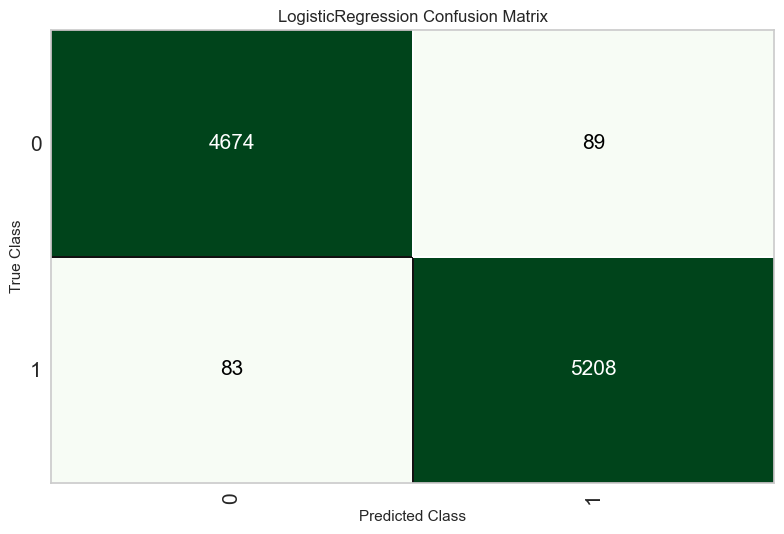

In [30]:
plot_model(tuned_lr_model, plot = 'confusion_matrix')

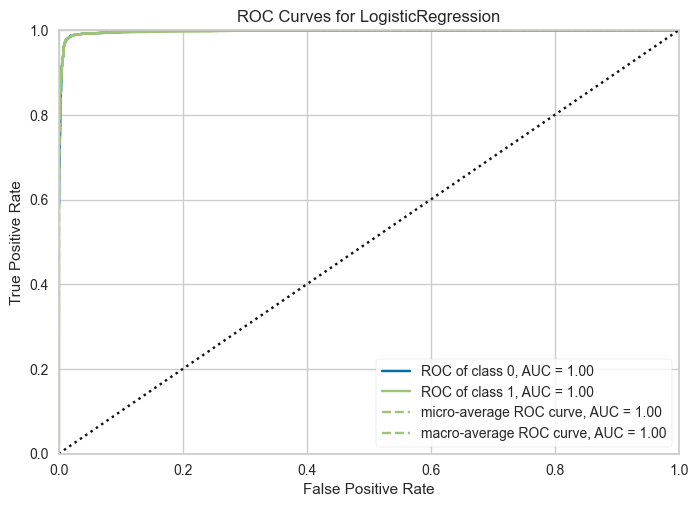

In [31]:
plot_model(tuned_lr_model, plot = 'auc')

In [32]:
tuned_svm_model= tune_model(svm_model, choose_better =True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9838,0.0000,0.9830,0.9862,0.9846,0.9675,0.9675
1,0.9804,0.0000,0.9773,0.9853,0.9812,0.9607,0.9607
2,0.9842,0.0000,0.9829,0.9869,0.9849,0.9684,0.9684
3,0.9876,0.0000,0.9846,0.9918,0.9882,0.9752,0.9753
4,0.9855,0.0000,0.9862,0.9862,0.9862,0.9709,0.9709
5,0.9829,0.0000,0.9894,0.9783,0.9838,0.9658,0.9659
6,0.9834,0.0000,0.9870,0.9814,0.9842,0.9666,0.9667
7,0.9859,0.0000,0.9846,0.9886,0.9866,0.9718,0.9718
8,0.9838,0.0000,0.9838,0.9854,0.9846,0.9675,0.9675


In [33]:
print(tuned_svm_model)

SGDClassifier(alpha=0.002, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001,
              fit_intercept=False, l1_ratio=0.9800000001,
              learning_rate='adaptive', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=1, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [34]:
print(svm_model)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


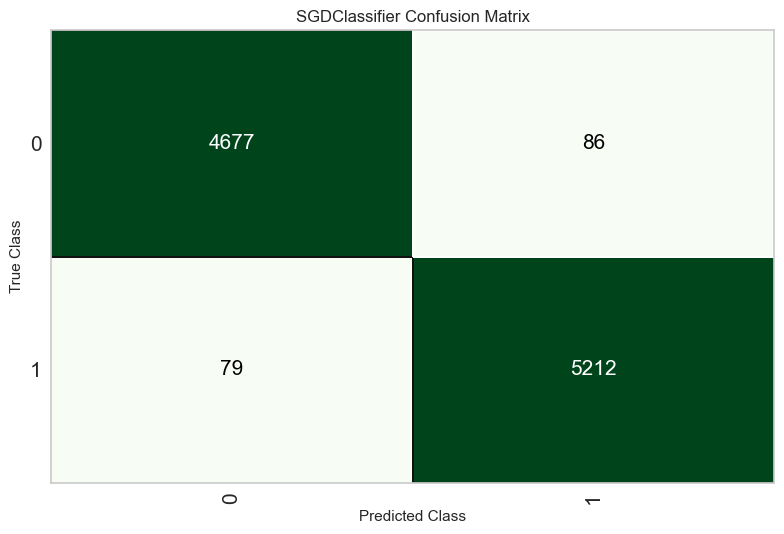

In [35]:
plot_model(tuned_svm_model, plot = 'confusion_matrix')

In [37]:
#plot_model(tuned_svm_model, plot = 'auc')

#### Validation on Holdout Set

In [38]:
predict_model(tuned_lightgbm_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9907,0.9994,0.9915,0.9907,0.9911,0.9812,0.9812


,10,100,100000,11,12,13,14,15,16,17,...,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label,Score
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9997
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9997
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9978
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9980
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9999
10050,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9974
10051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0000
10052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9979


In [39]:
predict_model(tuned_lr_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9829,0.9971,0.9843,0.9832,0.9838,0.9657,0.9657


,10,100,100000,11,12,13,14,15,16,17,...,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label,Score
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9999
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9997
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9998
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9986
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0000
10050,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9996
10051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0000
10052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9641


In [40]:
predict_model(tuned_svm_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9836,0.9835,0.9851,0.9838,0.9844,0.9671,0.9671


,10,100,100000,11,12,13,14,15,16,17,...,young,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
10050,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
10051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
10052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


#### Finalise Model

Training the model with the entire dataset

In [41]:
#light gradient boost machine model is the best model
final_lightgbm_model = finalize_model(tuned_lightgbm_model)

In [42]:
final_lr_model = finalize_model(tuned_lr_model)

In [43]:
final_svm_model = finalize_model(tuned_svm_model)

#### Finalise Model and Prediction of Test Dataset

In [44]:
test_df = pd.concat([X_test_cvec, y_test.reset_index(drop=True)], axis=1)

In [45]:
test_df.shape

(11170, 3001)

In [46]:
predict_model(final_lightgbm_model, data = test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9931,0.9996,0.9935,0.9934,0.9934,0.9862,0.9862


,10,100,100000,11,12,13,14,15,16,17,...,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9999
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9997
2,0,0,0,0,7,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0.9999
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,0,0,0,0,0,0,0,2,0,1,...,0,0,0,0,0,0,0,1,1,0.9988
11166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9997
11167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.0000
11168,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9998


In [47]:
predict_model(final_lr_model, data = test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9873,0.9979,0.9889,0.9869,0.9879,0.9745,0.9745


,10,100,100000,11,12,13,14,15,16,17,...,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0000
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.0000
2,0,0,0,0,7,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1.0000
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,0,0,0,0,0,0,0,2,0,1,...,0,0,0,0,0,0,0,1,1,1.0000
11166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9919
11167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.0000
11168,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.0000


In [48]:
predict_model(final_svm_model, data = test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9851,0.9851,0.9852,0.9865,0.9858,0.9702,0.9702


,10,100,100000,11,12,13,14,15,16,17,...,young,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,7,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,0,0,0,0,0,0,0,2,0,1,...,1,0,0,0,0,0,0,0,1,1
11166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
11168,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


#### Interpretation of Final (Best) Model

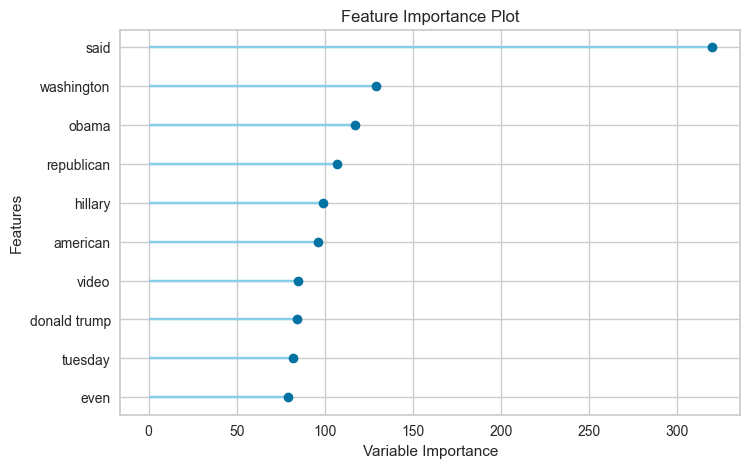

In [49]:
plot_model(final_lightgbm_model, plot = 'feature')

In [50]:
# to call out top 30 features
pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(final_lightgbm_model.feature_importances_)}).sort_values(by='Value', ascending=False).head(30)

,Feature,Value
2333,said,320
2889,washington,129
1814,obama,117
2238,republican,107
1255,hillary,99
166,american,96
2846,video,85
831,donald trump,84
2779,tuesday,82
942,even,79


In [51]:
# to call out bottom 30 features
pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(final_lightgbm_model.feature_importances_)}).sort_values(by='Value', ascending=False).tail(30)

,Feature,Value
1164,golf,0
1168,google,0
1170,gorsuch,0
1172,gotten,0
1174,government official,0
1175,government said,0
1177,graham,0
1178,grand,0
1179,grant,0
1180,granted,0


### Validation with Independent Dataset

In this section, i will evaluate the performance of my fake news detection model (with best estimator) with an unseen dataset which is an amalgamation of a total of 1000 news article of which 500 are articles labelled as real news and 500 fake news that were generated by GPT-2 (see for details of derivation of the fake news in notebook 1-1).

In [52]:
val_df = pd.read_csv('./datasets/val_df.csv')

In [53]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title_text  1000 non-null   object
 1   label       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [54]:
val_df.head()

,title_text,label
0,"Bobby Jindal, raised Hindu, uses story of Chri...",0
1,"May Brexit offer would hurt, cost EU citizens ...",0
2,Schumer calls on Trump to appoint official to ...,0
3,No Change Expected for ESPN Political Agenda D...,0
4,Billionaire Odebrecht in Brazil scandal releas...,0


In [55]:
# lower case the text
val_df['lower_case'] = val_df['title_text'].str.lower()

In [56]:
# remove website addresses from selftext_title column
# instantiate regex to identify and remove urls
val_df['drop_url'] = val_df['lower_case'].apply(lambda text: re.sub(r"http\S+", '', text))

In [57]:
# remove punctuations
val_df['drop_punctuations'] = val_df['drop_url'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

In [58]:
# tokenize
tokenizer = RegexpTokenizer(r"[\w']+") 
val_df['tokenized'] = val_df['drop_punctuations'].apply(lambda text: tokenizer.tokenize(text))

In [59]:
stopwords_list = stopwords.words("english")

# some words provided the source of the article, which may reveal explictly if the news is fake or real.Such words will be omitted to make the model less bias towards source
add_stopwords = ["21wire", "twitter", "reuters", '21WIRE', '21st', 'Century',  'Wire', 'somodevilla', 'getty', 'images', 'subscribe', 'member', 'realdonaldtrump']
stopwords_list.extend(add_stopwords)

In [60]:
# remove stopwords
val_df['drop_stopwords'] = val_df['tokenized'].apply(lambda value: [word for word in value if word not in stopwords_list])

In [61]:
# Instantiate Lemmatizer
lemmatizer = WordNetLemmatizer()
val_df['lemmatizer'] = val_df['drop_stopwords'].apply(lambda text:[lemmatizer.lemmatize(i) for i in text]) 

In [62]:
# Joining the list of words back into a string separated by space
val_df['lemmatizer_join'] = val_df['lemmatizer'].apply(lambda word: " ".join(word))

In [63]:
val_df['classification_text'] = val_df['lemmatizer_join']

In [64]:
# define X_val and y_val
X_val = val_df['classification_text']
y_val = val_df['label']

In [65]:
cvec = CountVectorizer(min_df=0.001, max_features=3000, ngram_range=(1,3))

In [66]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train.values).todense(), columns = cvec.get_feature_names())

In [67]:
# vectorization of val data set
X_val_cvec = pd.DataFrame(cvec.transform(X_val.values).todense(), columns = cvec.get_feature_names())

In [68]:
val_df = pd.concat([X_val_cvec, y_val.reset_index(drop=True)], axis=1)

In [69]:
val_df.shape

(1000, 3001)

In [70]:
unseen_pred = predict_model(final_lightgbm_model, data = val_df)
unseen_pred

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8460,0.9066,0.8980,0.8134,0.8536,0.6920,0.6958


,10,100,100000,11,12,13,14,15,16,17,...,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.9758
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9985
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9999
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.9525
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.7716
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9604
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9982
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0.9987


In [71]:
unseen_pred2 = predict_model(final_lr_model, data = val_df)
unseen_pred2

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8150,0.8464,0.8840,0.7768,0.8269,0.6300,0.6361


,10,100,100000,11,12,13,14,15,16,17,...,youre,youth,youtube,zero,zika,zimbabwe,zone,label,Label,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.9926
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9998
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9989
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.9970
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9996
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9999
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9999
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1.0000


### Review the wrong predictions based on unseen data test

In [72]:
# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 700

In [73]:
val_df = pd.read_csv('./datasets/val_df.csv')

In [74]:
pred = val_df.copy()
pred['prediction'] = unseen_pred['Label']

In [75]:
pred

,title_text,label,prediction
0,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while watching a movie during his senior year that depicted Jesus on the cross.\n\n“I was struck, and ...",0,1
1,"May Brexit offer would hurt, cost EU citizens - EU parliament BRUSSELS (Reuters) - British Prime Minister Theresa May s offer of settled status for EU residents is flawed and will leave them with fewer rights after Brexit, the European Parliament s Brexit coordinator said on Tuesday. A family of five could face a bill of 360 pounds to acquire the new status, Guy Verhofstadt told May s Brexit Secretary David Davis in a letter seen by Reuters a very significant amount for a family on low income . Listing three other concerns for the EU legislature, which must approve any treaty on the March 2019 exit, Verhofstadt told Davis: Under your proposals, EU citizens will definitely notice a ...",0,0
2,"Schumer calls on Trump to appoint official to oversee Puerto Rico relief WASHINGTON (Reuters) - Charles Schumer, the top Democrat in the U.S. Senate, called on President Donald Trump on Sunday to name a single official to oversee and coordinate relief efforts in hurricane-ravaged Puerto Rico. Schumer, along with Representatives Nydia Velàzquez and Jose Serrano, said a “CEO of response and recovery” is needed to manage the complex and ongoing federal response in the territory, where millions of Americans remain without power and supplies. In a statement, Schumer said the current federal response to Hurricane Maria’s impact on the island had been “disorganized, slow-footed and mismanaged.”...",0,0
3,"No Change Expected for ESPN Political Agenda Despite Huge Subscriber Decline - Breitbart As more and more sports fans turn off ESPN to protest the network’s social and political agenda, parent company Disney’s decision to extend current CEO Bob Iger’s contract through 2019 means the “world’s leader in sports entertainment” will continue on its merry way of alienating a large segment of Americans. [Breitbart reported in November that ESPN lost 3. 2 million subscribers in just over a year. Moreover, for the last few years the sports network has lost 300, 000 subscribers a month. In October alone, the beleaguered network lost 621, 000 subscribers. The decision to keep Iger instead of mo...",0,1
4,"Billionaire Odebrecht in Brazil scandal released to house arrest RIO DE JANEIRO/SAO PAULO (Reuters) - Billionaire Marcelo Odebrecht, the highest-profile executive imprisoned in Brazil s massive graft scandal, was released from jail on Tuesday to continue his sentence for corruption under house arrest, according to a federal court. The former chief executive officer of Odebrecht SA [ODBES.UL], Latin America s largest construction firm, was arrested in 2015 during an investigation dubbed Car Wash that exposed billions of dollars in kickbacks to politicians and executives at state-run companies in exchange for inflated contracts. Odebrecht was set to travel to Sao Paulo to begin his house a...",0,0
...,...,...,...
995,"Conservative Texas Lt. Governor Tweets Vile Bible Verse After Mass Shooting In LGBT Club Conservatives are already praising God for the murder of 20 or more people at an LGBT night club in Orlando, Florida.On Saturday night, a gunman walked into the club with an assault rifle and began shooting people. So far, at least 20 are confirmed dead but police say the death toll is likely to rise. ""It doesn't matter what hap

#### False Negatives

False negatives are fake news that are wrongly classified as real news

In [76]:
false_negative_df = pred[(pred['label'] ==1) & (pred['prediction']==0)]
false_negative_df.reset_index(drop =True, inplace =True)
false_negative_df  

,title_text,label,prediction
0,"SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly aggressive Russia It could deliver a warhead of 40 megatons – 2,000 times as powerful as the world bomb – to targets over the next few years. And the missiles can stay deployed long enough to damage satellites, ICBMs and aircraft up to 500 times faster than traditional atomic weapons The Russian Navy will not need to launch a warhead from its submarine base in the Mediterranean Sea to defend its territ...",1,0
1,"Sports Bar Owner Bans NFL Games…Will Show Only ‘True American’ Sports: ‘I’d like to speak for rural America’ [Video] The owner of the Ringling Bar, located south of White Sulphur Springs, is standing behind his Facebook post that criticizes NFL players who take a knee during the national anthem to protest police brutality. The post was made on the Ringling Bar s Facebook page Tuesday night and has since been shared more than 4,000 times. (Published Wednesday, Sept. 12, 2017)\n\nThe Facebook post from the owner of the Ringling bar about the protesters, who call themselves PEDIs, the National Guard and the Confederate flag, is in support of players who take a knee during the national anth...",1,0
2,"Latest Pipeline Leak Underscores Dangers Of Dakota Access Pipeline FILE – In this Sept. 15, 2005 file photo, the marker that welcomes commuters to Cushing, Okla. is seen. (AP Photo/The Oklahoman, Matt Strasen, File) Underscoring once again the dangers of America’s unreliable fossil fuel infrastructure, a significant U.S. oil pipeline has been shut down after a leak was reported . The leak caused a massive explosion that destroyed at least one car and caused a second, smaller blast, officials said Tuesday, Sept. 15, 2005. The rupture caused the leak for miles, causing an oil train to break a mile away in a suburb of Tulsa. (AP Photo/The Oklahoman, Steve DeClerk)\n\nAUSTIN - A huge oil lea...",1,0
3,"WATCH: HILARIOUS AD Calls Into Question Health Of Aging Clinton Crime Family Bosses After watching this telling video, you ll wonder if instead of working so hard to get back into the White House, Hillary s time would be better spent looking into an assisted living situation for her and Bill and watching her husband make love to her in a hotel with another woman.\n\nSo let us not hate on women or our elected officials but to have fun in our own country's elections!\n\n[Photo of Donald Trump via shutterstock.com ]<|endoftext|>A US air strike Tuesday claimed the life of a female soldier stationed abroad after the incident occurred in Yemen.\n\nThe strike, in central Yemen, the Yemeni Inte...",1,0
4,"THE ROBBING OF INNOCENCE: 12 Yr Old Students Given CDC Survey About Transgender, Gay And Oral Sex The left believes these are all perfectly acceptable topics to discuss with our young children. Whatever you do, just don t mention God!A public hearing is taking place Wednesday morning in the Massachusetts State House to look into a controversial sex survey given to middle school and high school students.Developed by researchers at the University of Virginia with funding from a national grant, the online survey asked students about their thoughts on sexual matters, and how they felt about their sexual life. The survey's sample size appears to be significantly smaller than reported.Accordi...",1,0
5,"AT&T, Time Warner and the Death of Privacy AT&T, Time Warner and the Death of Privacy By Amy Goodman and Denis Moynihan AT&T plans to buy Time Warner for $85.4 billion. ( Mark Lennihan / AP ) It has been 140 years since Alexander Graham Bell uttered the first words through his experimental telephone, to his lab assistant: \n\n""Bell Telephone Laboratories, Inc., and to whom is committed the obligations of the third degree...""\n

#### False Positives

Fals epositives are real news being classified as fake news.

In [77]:
false_positive_df = pred[(pred['label'] ==0) & (pred['prediction']==1)]
false_positive_df.reset_index(drop =True, inplace =True)
false_positive_df

,title_text,label,prediction
0,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Catholic.”\n\nOver two hours, Jindal, 42, recalled talking with a girl in high school who wanted to “save my soul,” reading the Bible in a closet so his parents would not see him and feeling a stir while watching a movie during his senior year that depicted Jesus on the cross.\n\n“I was struck, and ...",0,1
1,"No Change Expected for ESPN Political Agenda Despite Huge Subscriber Decline - Breitbart As more and more sports fans turn off ESPN to protest the network’s social and political agenda, parent company Disney’s decision to extend current CEO Bob Iger’s contract through 2019 means the “world’s leader in sports entertainment” will continue on its merry way of alienating a large segment of Americans. [Breitbart reported in November that ESPN lost 3. 2 million subscribers in just over a year. Moreover, for the last few years the sports network has lost 300, 000 subscribers a month. In October alone, the beleaguered network lost 621, 000 subscribers. The decision to keep Iger instead of mo...",0,1
2,"Sekulow: Expect ‘Whining Testimony’ from Comey ‘He Needs to ‘Grow up and Act Like an Adult’ Jay Sekulow, Chief Counsel of the American Center for Law and Justice joined Breitbart News Daily SiriusXM host Raheem Kassam on Wednesday to discuss the coming testimony of former FBI Director James Comey and the case of Reality Winner, who was arrested for leaking secrets from the National Security Agency. [Said Sekulow on Comey, “He’s not exactly a credible witness,” while pointing out several previous issues with testimony he’s given that has to be corrected later. As for what to expect now, said Sekulow, “You don’t want to be left alone with the President of the United States? Well, that’s w...",0,1
3,"An Architect Who Built His Career on Resuscitating New York Landmarks - The New York Times Grand Central Terminal, the main building on Ellis Island and the Enid A. Haupt Conservatory at the New York Botanical Garden — all among the greatest New York City landmarks — look better today than they have since their earliest years. Many hands were responsible. John Belle was the common denominator. Mr. Belle, the retired founding partner of Beyer Blinder Belle, an architectural and planning firm that has specialized in preservation, restoration and contextual design, died last week at 84. With his death, the city has lost an architect who conveyed a genial joy in resuscitating the maste...",0,1
4,"Delingpole: Top Physicist and Leading Republicans Urge Trump to Quit Paris Climate Agreement Should Donald Trump hamstring the U. S. economy, rip off the consumer, despoil the landscape, give succour to America’s enemies and promote junk science — all in order to keep a “seat at the table” with people who despise him and think he’s an idiot? [To some people — including several senior members of the Trump administration — the answer isn’t immediately obvious. Which is why this week both a leading U. S. scientist and a number of top Senate Republicans have had to urge the president to see sense and ignore the siren voices urging him to stay in the UN’s Paris climate agreement. Th...",0,1
...,...,...,...
98,"Jury selection begins in Colorado theater shooting trial CENTENNIAL, Colo. — Gone are the orange hair and the thousand-yard stare. In their place, trimmed hair, a shaggy beard and red-framed glasses.\n\nSitting upright in court in a dark jacket, blue striped shirt and khaki slacks, James Holmes looking very much like the neuroscience graduate student he used to be, not a man on trial for his life.\n\nBut Holmes, now 27, faces 12

Observation:

- Text that have speech-like / informal choice of words tend to be erroneously classified as fake news (false positives). This is likely due to the model being trained with dataset which have a large number of data which uses speech-like language/ text to portray fake news